## Project 7: Self-supervised single-image depth-estimation using neural-networks

### Authors:
#### ◘ Sharhad Bashar
#### ◘ Lizhe Chen
#### ◘ Genséric Ghiro
#### ◘ Futian Zhang

## 1) Abstract: In a few short sentences highlighting the main points of the project.

## 2) Introduction (3-4 paragraphs): reviewing your topic, related technical ideas/algorithms, your selected methodology/approach, its motivation)

Data part:

The kitti dataset was downloaded from http://www.cvlibs.net/download.php?file=data_depth_selection.zip. We unzipped them and used the python script “dataCreator.py” to convert PNG files to JPG files in order to reduce the file size. There are 5882 pairs of Left and Right pictures for training and 500 pairs for validation.

We used dataLoader.py to load the jpg files to tensor in PyTorch. In the class TwoViewDataset, it receives data path, resize shape, a flag to identify training or validating, transforms for data augmentation, sanity check flag to perform overfitting condition, and color mode setting string to convert the data to RGB or grayscale. It reads the corresponding data from training or validation path. In the getitem method, we first read the pictures and convert them to the shape and color space passed from the init function. Then it will process the transforms. It could be some data augmentation or just to tensor directly. It will return the pairs of pictures after everything is done.

In the data augmentation part, we first create some classes as what we did in the Assignment 4. First, JointRandomFilp class random horizontally flips two pictures with a probability of 0.5. If the pair is flipped, then it will be swapped with each other to make sure that the relative position is still left and right. We also added JointRandomColorAug to augment the color to make the training more robust and avoid overfitting. It changes the gamma, brightness and saturate. We also implement JointToTensor and JointToImage to convert between PyTorch tensor and Pillow image. We reused JointCompose in A04 to convert the pair of pictures together. Here is the VGG model structure:

<img src="vgg_model.png"> 

We used the pretrained VGG16_bn model from pytorch build-in model. VGG network used two layers 3*3 Kernels to replace one 5*5 Kernel in Alexnet to collect feature from the same part of 5*5 pixels, which makes the network deeper. VGG16_bn used batch norm to speed up the training and avoid the gradient vanishing problem and gradient exploding problem for such a deep network. We display the VGG16_bn model, and store the result at the beginning and before each pooling layer for skipping later. There are 5 skip layers in total. We only used the first 43 layers because we need to rebuild the right picture and layers later than are used to classification. The rest part of the network is the same as our Resnet model.

## 3) Contributions section: This section should have one separate short paragraph (or a bullet) dedicated to each co-author clearly indicating her/his specific contributions. 

#### Sharhad Bashar:
       •
       •
       •
       
#### Lizhe Chen:
       •
       •
       •
       
#### Genséric Ghiro:
       • Research papers reading
       • Helped in the design of the network
       • Redaction of the final report
       
#### Futian Zhang:
       • Implement data loader to load the dataset.
       • Implement the data augmentation.
       • Tried to setup the project to Colab.
       • Implement VGG model for training.
       • Help integrate the project together.

## 4) Outline section: the overall structure/organization of the report

5aa) Imports
5a) Dataloader
5b) Network
5c) Validator
5d) Trainer
5e) Training
6) Results display
7) Conclusion
8) References

## 5aa) Imports

In [4]:
%matplotlib inline

In [3]:
from __future__ import absolute_import, division, print_function


import scipy
import skimage
from scipy.sparse.linalg import spsolve

import os
import glob
import random
import numpy as np
import copy
from PIL import Image 
import torch
import time
from matplotlib import pyplot as plt

#5a)
import torch.utils.data as data
from torchvision import transforms
import torchvision.transforms.functional as tF

#5b)
import torch.nn as nn
import torch.nn.functional as F
import importlib
import torchvision.models as models
from loss import MonodepthLoss #make sure loss.py is in folder

#5c) 
import torch.optim as optim
from torch.utils.data import DataLoader

#5d)
import pickle

#5e)
from torch.utils.data.dataloader import *

## 5a) Dataloader

In [5]:
class JointRandomFlip(object):
    def __call__(self, L, R):
        if np.random.random_sample()>0.5:
            return (tF.hflip(R),tF.hflip(L))
        return (L,R)
       
class JointRandomColorAug(object):

    def __init__(self,gamma=(0.8,1.2),brightness=(0.5,2.0),color_shift=(0.8,1.2)):
        self.gamma = gamma
        self.brightness = brightness
        self.color_shift = color_shift

    def __call__(self, L, R):
        if  np.random.random_sample()>0.5:
            
            random_gamma = np.random.uniform(*self.gamma)
            L_aug = L ** random_gamma
            R_aug = R ** random_gamma

            random_brightness = np.random.uniform(*self.brightness)
            L_aug = L_aug * random_brightness
            R_aug = R_aug * random_brightness

            random_colors = np.random.uniform(self.color_shift[0],self.color_shift[1], 3)
            for i in range(3):
                L_aug[i, :, :] *= random_colors[i]
                R_aug[i, :, :] *= random_colors[i]

            # saturate
            L_aug = torch.clamp(L_aug, 0, 1)
            R_aug = torch.clamp(R_aug, 0, 1)

            return L_aug, R_aug

        else:
            return L, R

class JointToTensor(object):
    def __call__(self, L, R):
        return tF.to_tensor(L),tF.to_tensor(R)
    
class JointToImage(object):
    def __call__(self, L, R):
        return transforms.ToPILImage()(L),transforms.ToPILImage()(R)
    
    
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target


class TwoViewDataset(data.Dataset):
    
    def __init__(self, 
                 data_path,
                 resize_shape=(512,256), 
                 is_train=False,
                 transforms=None,
                 sanity_check=None,
                 color='RGB'):
        super(TwoViewDataset, self).__init__()
        self.data_path = data_path

        self.interp = Image.ANTIALIAS
        self.resize_shape = resize_shape
        self.is_train = is_train
        self.transforms=transforms
        self.color = color
        
        if is_train:
            self.imgR_folder = os.path.join(data_path, "train", "image_right")
            self.imgL_folder = os.path.join(data_path, "train", "image_left")
        else:
            self.imgR_folder = os.path.join(data_path, "val", "image_right")
            self.imgL_folder = os.path.join(data_path, "val", "image_left")
        
        
        self.imgR=[os.path.join(self.imgR_folder, x) for x in os.listdir(self.imgR_folder)]
        self.imgL=[os.path.join(self.imgL_folder, x) for x in os.listdir(self.imgL_folder)]


    def __len__(self):
        return len(list(glob.glob1(self.imgL_folder, "*.jpg")))

    def __getitem__(self, index):
        #print(np.array(Image.open(self.imgR[index]).convert('RGB')).shape)
        colorR=Image.open(self.imgR[index]).convert(self.color).resize(self.resize_shape)
        colorL=Image.open(self.imgL[index]).convert(self.color).resize(self.resize_shape)
        #print(np.array(colorR).shape)
        
        if self.transforms is not None:
            colorR, colorL = self.transforms(colorR, colorL)
        return colorL, colorR


class GroundTruth(data.Dataset):
    def __init__(self, 
                 data_path,
                 resize_shape=(512,256), 
                 is_train=False,
                 transforms=JointToTensor(),
                 sanity_check=None):
        super(GroundTruth, self).__init__()
        self.data_path = data_path

        self.interp = Image.ANTIALIAS
        self.resize_shape = resize_shape
        self.is_train = is_train
        self.transforms=transforms
        self.loader = pil_loader
        
        self.imgR_folder = os.path.join(data_path, "val", "image_right")
        self.imgL_folder = os.path.join(data_path, "val", "image_left")
        self.gtR_folder = os.path.join(data_path, "val", "gt_right")
        self.gtL_folder = os.path.join(data_path, "val", "gt_left")
        
        self.imgR=[os.path.join(self.imgR_folder, x) for x in os.listdir(self.imgR_folder)]
        self.imgL=[os.path.join(self.imgL_folder, x) for x in os.listdir(self.imgL_folder)]
        self.gtR=[os.path.join(self.gtR_folder, x) for x in os.listdir(self.gtR_folder)]
        self.gtL=[os.path.join(self.gtL_folder, x) for x in os.listdir(self.gtL_folder)]

    def depth_read(self, filename):

        depth_png = np.array(Image.open(filename).resize(self.resize_shape), dtype=int)
        assert(np.max(depth_png) > 255)

        depth = depth_png.astype(np.float) / 256.
        depth[depth_png == 0] = -1.
        return depth


    def get_color(self, path, do_flip):
        color = self.loader(path)
        if do_flip:
            color = color.transpose(Image.FLIP_LEFT_RIGHT)
        return self.to_tensor(color)

    def depth_colorization(self, imgRgb=None, imgDepthInput=None, alpha=1):
        imgIsNoise = imgDepthInput == 0
        maxImgAbsDepth = np.max(imgDepthInput)
        imgDepth = imgDepthInput / maxImgAbsDepth
        imgDepth[imgDepth > 1] = 1
        (H, W) = imgDepth.shape
        numPix = H * W
        indsM = np.arange(numPix).reshape((W, H)).transpose()
        knownValMask = (imgIsNoise == False).astype(int)
        grayImg = skimage.color.rgb2gray(imgRgb)
        winRad = 1
        len_ = 0
        absImgNdx = 0
        len_window = (2 * winRad + 1) ** 2
        len_zeros = numPix * len_window

        cols = np.zeros(len_zeros) - 1
        rows = np.zeros(len_zeros) - 1
        vals = np.zeros(len_zeros) - 1
        gvals = np.zeros(len_window) - 1

        for j in range(W):
            for i in range(H):
                nWin = 0
                for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
                    for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
                        if ii == i and jj == j:
                            continue

                        rows[len_] = absImgNdx
                        cols[len_] = indsM[ii, jj]
                        gvals[nWin] = grayImg[ii, jj]

                        len_ = len_ + 1
                        nWin = nWin + 1

                curVal = grayImg[i, j]
                gvals[nWin] = curVal
                c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

                csig = c_var * 0.6
                mgv = np.min((gvals[:nWin] - curVal) ** 2)
                if csig < -mgv / np.log(0.01):
                    csig = -mgv / np.log(0.01)

                if csig < 2e-06:
                    csig = 2e-06

                gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
                gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
                vals[len_ - nWin:len_] = -gvals[:nWin]

                # Now the self-reference (along the diagonal).
                rows[len_] = absImgNdx
                cols[len_] = absImgNdx
                vals[len_] = 1  # sum(gvals(1:nWin))

                len_ = len_ + 1
                absImgNdx = absImgNdx + 1

        vals = vals[:len_]
        cols = cols[:len_]
        rows = rows[:len_]
        A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

        rows = np.arange(0, numPix)
        cols = np.arange(0, numPix)
        vals = (knownValMask * alpha).transpose().reshape(numPix)
        G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

        A = A + G
        b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

        #print ('Solving system..')

        new_vals = spsolve(A, b)
        new_vals = np.reshape(new_vals, (H, W), 'F')

        #print ('Done.')

        denoisedDepthImg = new_vals * maxImgAbsDepth
        
        output = denoisedDepthImg.reshape((H, W)).astype('float32')

        output = np.multiply(output, (1-knownValMask)) + imgDepthInput
        
        return output

    def __len__(self):
        return len(list(glob.glob1(self.imgL_folder, "*.jpg")))

    def __getitem__(self, index):
        #print(np.array(Image.open(self.imgR[index]).convert('RGB')).shape)
        colorR=Image.open(self.imgR[index]).convert('RGB').resize(self.resize_shape)
        colorL=Image.open(self.imgL[index]).convert('RGB').resize(self.resize_shape)
        #print(np.array(colorR).shape)
        gtR=self.depth_read(self.gtR[index])
        gtL=self.depth_read(self.gtL[index])


        colorR_N = np.array(colorR)/255.0
        colorL_N = np.array(colorL)/255.0


        gtR = self.depth_colorization(imgRgb=colorR_N, imgDepthInput=gtR, alpha=1)
        gtL = self.depth_colorization(imgRgb=colorL_N, imgDepthInput=gtL, alpha=1)
        
        # if self.transforms is not None:
        #     colorR, colorL = self.transforms(colorR, colorL)
        #     gtR, gtL = self.transforms(gtR, gtL)


        return gtL, gtR

## 5b) Network 1 (with Resnet18 as encoder) and Network 2 (with VGG16 as encoder)

In [6]:
class get_disp(nn.Module):
    def __init__(self, num_in_channels):
        super(get_disp, self).__init__()
        self.p2d = (1, 1, 1, 1)
        self.disp = nn.Sequential(nn.Conv2d(num_in_channels, 2, kernel_size=3, stride=1),
                                  nn.BatchNorm2d(2),
                                  torch.nn.Sigmoid())

    def forward(self, x):
        x = self.disp(F.pad(x, self.p2d))
        return 0.3 * x


class iconv(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, stride):
        super(iconv, self).__init__()
        p = int(np.floor((kernel_size - 1) / 2))
        self.p2d = p2d = (p, p, p, p)

        self.iconv = nn.Sequential(nn.Conv2d(num_in_channels, num_out_channels, kernel_size=kernel_size, stride=stride),
                                  nn.BatchNorm2d(num_out_channels))

    def forward(self, x):
        x = self.iconv(F.pad(x, self.p2d))
        return F.elu(x, inplace=True)


class iconv_dilate(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, stride, dilation):
        super(iconv, self).__init__()
        p = int(np.floor((kernel_size - 1) / 2))
        self.p2d = p2d = (p, p, p, p)

        self.iconv = nn.Sequential(nn.Conv2d(num_in_channels, num_out_channels, kernel_size=kernel_size, stride=stride, dilation=dilation),
                                  nn.BatchNorm2d(num_out_channels))

    def forward(self, x):
        x = self.iconv(F.pad(x, self.p2d))
        return F.elu(x, inplace=True)

class upconv(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = iconv(num_in_channels, num_out_channels, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

class upconv_dilate(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, scale, dilation):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = iconv(num_in_channels, num_out_channels, kernel_size, 1, dilation)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

    
###################### NETWORK 1 ######################
class ResnetDispModel(nn.Module):

    def __init__(self, num_input_channel=3, encoder='resnet18', pretrained=True, dilate=False):
        super(ResnetDispModel, self).__init__()
        self.num_input_channel = num_input_channel


        assert encoder in ['resnet18', 'resnet34', 'resnet50', \
                           'resnet101', 'resnet152'], \
            "Incorrect encoder type"
        if encoder in ['resnet18', 'resnet34']:
            filters = [64, 128, 256, 512]
        else:
            filters = [256, 512, 1024, 2048]



        resnet = getattr(importlib.import_module("torchvision.models"), encoder)(pretrained=pretrained)
        resnet_pool1 = list(resnet.children())[1:4]

        self.conv1 = resnet.conv1
        self.maxpool = nn.Sequential(*resnet_pool1)

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        if dilate:
            self.upconv6 = upconv(filters[3], 512, 3, 2, 2)
            self.iconv6 = iconv_dilate(filters[2] + 512, 512, 3, 1, 2)

            self.upconv5 = upconv(512, 256, 3, 2, 3)
            self.iconv5 = iconv_dilate(filters[1] + 256, 256, 3, 1, 4)
        else:
            self.upconv6 = upconv(filters[3], 512, 3, 2)
            self.iconv6 = iconv(filters[2] + 512, 512, 3, 1)

            self.upconv5 = upconv(512, 256, 3, 2)
            self.iconv5 = iconv(filters[1] + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = iconv(filters[0] + 128, 128, 3, 1)
        self.disp4_layer = get_disp(128)

        self.upconv3 = upconv(128, 64, 3, 1) #
        self.iconv3 = iconv(64 + 64 + 2, 64, 3, 1)
        self.disp3_layer = get_disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = iconv(64 + 32 + 2, 32, 3, 1)
        self.disp2_layer = get_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.disp1_layer = get_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # encoder
        x_conv1 = self.conv1(x)
        x_pool1 = self.maxpool(x_conv1)
        x1 = self.layer1(x_pool1)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # skips
        skip1 = x_conv1
        skip2 = x_pool1
        skip3 = x1
        skip4 = x2
        skip5 = x3

        # decoder
        upconv6 = self.upconv6(x4)
        concat6 = torch.cat((upconv6, skip5), 1)
        iconv6 = self.iconv6(concat6)

        upconv5 = self.upconv5(iconv6)
        concat5 = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)
        self.udisp4 = nn.functional.interpolate(self.disp4, scale_factor=1, mode='bilinear', align_corners=True)
        self.disp4 = nn.functional.interpolate(self.disp4, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        concat3 = torch.cat((upconv3, skip2, self.udisp4), 1)
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = nn.functional.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, self.udisp3), 1)
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)
        
        return self.disp1, self.disp2, self.disp3, self.disp4
    
###################### NETWORK 2 ######################
class VGGDispModel(nn.Module):
    def __init__(self, num_input_channel = 3, encoder='vgg16', pretrained=True):
        super(VGGDispModel, self).__init__()
        self.num_input_channel = num_input_channel

        vgg16_bn = models.vgg16_bn(pretrained=True)
        # pretrained_dict = vgg16.state_dict()
        # model_dict = vgg16.state_dict()
        #
        # pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        # model_dict.update(pretrained_dict)
        # vgg16.load_state_dict(model_dict)

        filters = [64, 128, 256, 512]
        layers = list(vgg16_bn.children())[0]
        self.conv1 = layers[0]
        self.layer0 = nn.Sequential(*layers[1:6])
        self.layer1 = nn.Sequential(*layers[6:13])
        self.layer2 = nn.Sequential(*layers[13:23])
        self.layer3 = nn.Sequential(*layers[23:33])
        self.layer4 = nn.Sequential(*layers[33:43])


        self.upconv6 = upconv(filters[3], 512, 3, 2)
        self.iconv6 = iconv(filters[2] + 512, 512, 3, 1)

        self.upconv5 = upconv(512, 256, 3, 2)
        self.iconv5 = iconv(filters[1] + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = iconv(filters[0] + 128, 128, 3, 1)
        self.disp4_layer = get_disp(128)

        self.upconv3 = upconv(128, 64, 3, 1) #
        self.iconv3 = iconv(64 + 64 + 2, 64, 3, 1)
        self.disp3_layer = get_disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = iconv(64 + 32 + 2, 32, 3, 1)
        self.disp2_layer = get_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.disp1_layer = get_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # encoder
        x_conv1=self.conv1(x)
        x0 = self.layer0(x_conv1)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # skips
        skip1 = x_conv1
        skip2 = x0
        skip3 = x1
        skip4 = x2
        skip5 = x3
        # print(skip4.size())

        # decoder
        upconv6 = self.upconv6(x4)
        concat6 = torch.cat((upconv6, skip5), 1)
        iconv6 = self.iconv6(concat6)

        upconv5 = self.upconv5(iconv6)
        # print(upconv5.size())
        concat5 = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)
        self.udisp4 = nn.functional.interpolate(self.disp4, scale_factor=1, mode='bilinear', align_corners=True)
        self.disp4 = nn.functional.interpolate(self.disp4, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        concat3 = torch.cat((upconv3, skip2, self.udisp4), 1)
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = nn.functional.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, self.udisp3), 1)
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)
        
        return self.disp1, self.disp2, self.disp3, self.disp4

## 5c) Validator

In [7]:
class Validator:
    def __init__(self, val_loader, batch_size, params_file=None, use_gpu=False):
        self.use_gpu = use_gpu
        self.params_file = params_file
        self.val_loader = val_loader
        if use_gpu :
            self.device = "cuda:0"
        else:
            self.device = "cpu"
        self.loss = MonodepthLoss(
            n=4,
            SSIM_w=0.85,
            disp_gradient_w=0.1, lr_w=1).to(self.device)
        self.val_losses = []
        self.batch_size = batch_size


    def validate(self, network):

        network.eval()

        total_loss = 0
        counter = 0
        for i, data in enumerate(self.val_loader):
            left, right = data

            if self.use_gpu:
                left = left.cuda()
                network = network.cuda()
                right = right.cuda()

            model_outputs = network(left)

            loss = self.loss(model_outputs, [left, right])
            self.val_losses.append(loss.item())
            total_loss += loss.item()
            counter += 1

        total_loss /= counter

        return total_loss


## 5d) Trainer

In [53]:
class Trainer:
    def __init__(self, network, train_loader, optimizer, batch_size, model, params_file=None, use_gpu=False):
        self.net = network
        self.use_gpu = use_gpu
        self.optimizer = optimizer
        self.validator = None
        self.history = {"Train": [], "Val": []}
        self.params_file = params_file
        self.train_loader = train_loader
        self.batch_size = batch_size
        self.model = model
        if use_gpu :
            self.device = "cuda:0"
        else:
            self.device = "cpu"

        self.loss_function = MonodepthLoss(
            n=4,
            SSIM_w=0.85,
            disp_gradient_w=0.1, lr_w=1).to(self.device)


    def setValidator(self, validator):
        self.validator = validator

    def setOptimizer(self, opt):
        self.optimizer = opt

    def saveParams(self, path):
        torch.save(self.net.state_dict(), path)

    def loadModel(self, path):
        self.net.load_state_dict(torch.load(path))

    def train(self):
        total_loss = 0.0

        self.net.train()
        counter = 0
        for i, data in enumerate(self.train_loader):
            left, right = data
            if self.use_gpu:
                left = left.cuda()
                self.net = self.net.cuda()
                right = right.cuda()


            self.optimizer.zero_grad()
            disps = self.net(left)
            loss = self.loss_function(disps, [left, right])
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            counter += 1

        main_loss = total_loss / counter

        return main_loss

    def run_train(self, epoch):
        if self.params_file:
            self.loadModel(self.params_file)
        save_name = "params" + self.model + ".pkl"
        prev_score = np.inf
        if self.validator:
            prev_score = self.validator.validate(self.net)

        for e in range(epoch):

            loss = self.train()
            print("Epoch: {} Loss: {}".format(e, loss))
            self.history["Train"].append(loss)

            if self.validator:
                val_score = self.validator.validate(self.net)
                self.history["Val"].append(val_score)
                if val_score < prev_score:
                    print("update model file with prev_score {} and current score {}".format(prev_score, val_score))
                    self.saveParams(save_name)
                    prev_score = val_score

            with open("train_history" + self.model + ".pickle", 'wb') as handle:
                pickle.dump(self.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def copyNetwork(self):
        return copy.deepcopy(self.net)

## 5e) Training Network with Resnet18 Encoder

In [49]:
use_gpu = False
# NUM_WORKERS must be 0 for Windows (can be anything else otherwise)
num_workers = 0
use_pretrained_params = False
epochs = 50

val_dataset = TwoViewDataset("dataset/dataset/", is_train=False, transforms=JointToTensor())
trn_dataset = TwoViewDataset("dataset/dataset/", is_train=True, transforms=JointToTensor())
val_loader = data.DataLoader(val_dataset, batch_size=16, num_workers=num_workers, shuffle=False)
trn_loader = data.DataLoader(trn_dataset, batch_size=8, num_workers=num_workers, shuffle=False)

In [54]:
networkRes = ResnetDispModel(3)

if use_pretrained_params: #make sure to have paramsRes.pkl in the folder
    networkRes.load_state_dict(torch.load("paramsRes.pkl", map_location=torch.device('cpu')))
    networkRes.eval()
else:  
    val_Res = Validator(val_loader, 1, use_gpu)
    opt_Res = torch.optim.SGD(networkRes.parameters(), lr=1e-2, weight_decay=1e-6,momentum=0.5, nesterov=False)
    trn_Res = Trainer(networkRes, trn_loader, opt_Res, 8, model = "Res", use_gpu=use_gpu)
    trn_Res.setValidator(val_Res)
    trn_Res.run_train(epochs)
    trained_net_res = networkRes

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1358954496 bytes. Buy new RAM!


## 5f) Training Network with VGG16 Encoder

In [42]:
networkVGG = VGGDispModel(3)

if use_pretrained_params: #make sure to have paramsVGG.pkl in the folder
    networkVGG.load_state_dict(torch.load("paramsVGG.pkl", map_location=torch.device('cpu')))
    networkVGG.eval()
else:  
    val_VGG = Validator(val_loader, 1, use_gpu)
    opt_VGG = torch.optim.SGD(networkVGG.parameters(), lr=1e-2, weight_decay=1e-6,momentum=0.5, nesterov=False)
    trn_VGG = Trainer(networkVGG, trn_loader, opt, 8, model = "VGG", use_gpu=use_gpu)
    trn_VGG.setValidator(val_VGG)
    trn_VGG.run_train(epochs)
    trained_net_VGG = networkVGG

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\getty/.cache\torch\checkpoints\vgg16_bn-6c64b313.pth
100%|████████████████████████████████████████████████████████████████████████████████| 528M/528M [10:05<00:00, 915kB/s]


RuntimeError: Error(s) in loading state_dict for VGGDispModel:
	Missing key(s) in state_dict: "conv1.bias", "layer0.0.weight", "layer0.0.bias", "layer0.0.running_mean", "layer0.0.running_var", "layer0.2.weight", "layer0.2.bias", "layer0.3.weight", "layer0.3.bias", "layer0.3.running_mean", "layer0.3.running_var", "layer1.1.weight", "layer1.1.bias", "layer1.2.weight", "layer1.2.bias", "layer1.2.running_mean", "layer1.2.running_var", "layer1.4.weight", "layer1.4.bias", "layer1.5.weight", "layer1.5.bias", "layer1.5.running_mean", "layer1.5.running_var", "layer2.1.weight", "layer2.1.bias", "layer2.2.weight", "layer2.2.bias", "layer2.2.running_mean", "layer2.2.running_var", "layer2.4.weight", "layer2.4.bias", "layer2.5.weight", "layer2.5.bias", "layer2.5.running_mean", "layer2.5.running_var", "layer2.7.weight", "layer2.7.bias", "layer2.8.weight", "layer2.8.bias", "layer2.8.running_mean", "layer2.8.running_var", "layer3.1.weight", "layer3.1.bias", "layer3.2.weight", "layer3.2.bias", "layer3.2.running_mean", "layer3.2.running_var", "layer3.4.weight", "layer3.4.bias", "layer3.5.weight", "layer3.5.bias", "layer3.5.running_mean", "layer3.5.running_var", "layer3.7.weight", "layer3.7.bias", "layer3.8.weight", "layer3.8.bias", "layer3.8.running_mean", "layer3.8.running_var", "layer4.1.weight", "layer4.1.bias", "layer4.2.weight", "layer4.2.bias", "layer4.2.running_mean", "layer4.2.running_var", "layer4.4.weight", "layer4.4.bias", "layer4.5.weight", "layer4.5.bias", "layer4.5.running_mean", "layer4.5.running_var", "layer4.7.weight", "layer4.7.bias", "layer4.8.weight", "layer4.8.bias", "layer4.8.running_mean", "layer4.8.running_var". 
	Unexpected key(s) in state_dict: "maxpool.0.weight", "maxpool.0.bias", "maxpool.0.running_mean", "maxpool.0.running_var", "maxpool.0.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).

## 6) Results

In [44]:
val_loader = data.DataLoader(val_dataset, batch_size=1, num_workers=num_workers, shuffle=True)

for left, right in val_loader:
    sample = left
    break

disp1_Res, disp2_Res, disp3_Res, disp4_Res = networkRes(sample)
#disp1_VGG, disp2_VGG, disp3_VGG, disp4_VGG = networkVGG(sample)

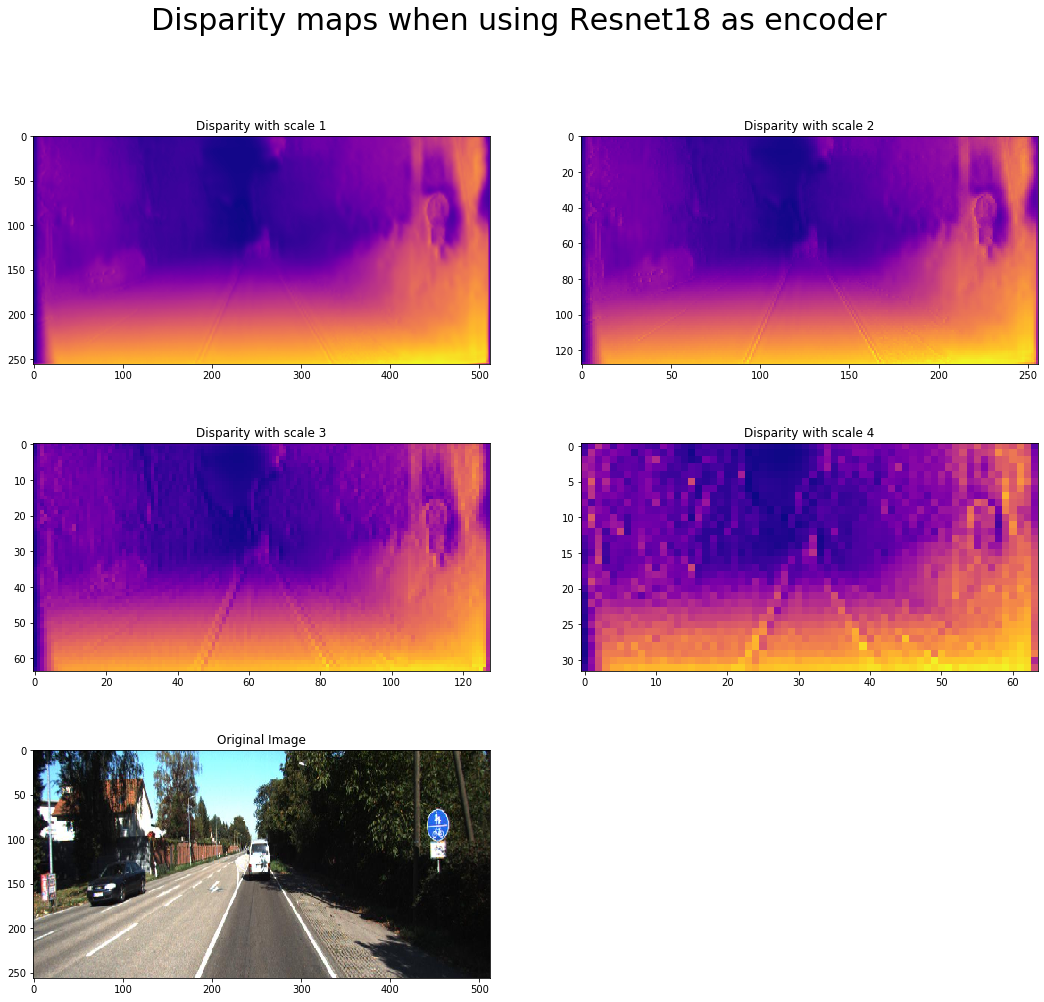

In [45]:
plt.figure(2, figsize=(18, 16))
plt.suptitle("Disparity maps when using Resnet18 as encoder", fontsize=30)
plt.subplot(321)
plt.imshow(np.squeeze(np.array(disp1_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 1")
plt.subplot(322)
plt.imshow(np.squeeze(np.array(disp2_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 2")
plt.subplot(323)
plt.imshow(np.squeeze(np.array(disp3_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 3")
plt.subplot(324)
plt.imshow(np.squeeze(np.array(disp4_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 4")
plt.subplot(325)
plt.imshow(np.transpose(np.squeeze(np.array(sample)), axes=(1,2,0)))
plt.title("Original Image")
plt.show()

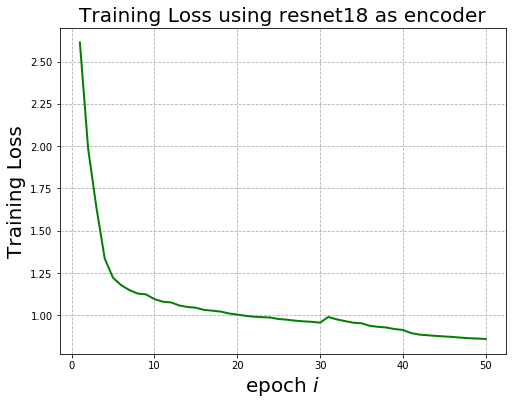

In [48]:
with open('train_historyRes.pickle', 'rb') as handle:
    data_Res = pickle.load(handle)
epoch = np.arange(epochs) + 1
fig = plt.figure(3, figsize=(8, 6))
plt.plot(epoch, data_Res["Train"], linewidth=2.0, color ="green")
plt.title("Training Loss using resnet18 as encoder", size = 20)
plt.xlabel("epoch $i$", fontsize=20)
plt.ylabel("Training Loss", fontsize=20)
plt.grid(linestyle='dashed')
plt.show()

In [ ]:
plt.figure(4, figsize=(18, 16))
plt.suptitle("Disparity maps when using VGG16 as encoder", fontsize=30)
plt.subplot(321)
plt.imshow(np.squeeze(np.array(disp1_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 1")
plt.subplot(322)
plt.imshow(np.squeeze(np.array(disp2_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 2")
plt.subplot(323)
plt.imshow(np.squeeze(np.array(disp3_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 3")
plt.subplot(324)
plt.imshow(np.squeeze(np.array(disp4_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 4")
plt.subplot(325)
plt.imshow(np.transpose(np.squeeze(np.array(sample)), axes=(1,2,0)))
plt.title("Original Image")
plt.show()

In [ ]:
with open('train_historyVGG.pickle', 'rb') as handle:
    data_VGG = pickle.load(handle)
epoch = np.arange(epochs) + 1
fig = plt.figure(5, figsize=(8, 6))
plt.plot(epoch, data_VGG["Train"], linewidth=2.0, color ="green")
plt.title("Training Loss using vgg16 as encoder", size = 20)
plt.xlabel("epoch $i$", fontsize=20)
plt.ylabel("Training Loss", fontsize=20)
plt.grid(linestyle='dashed')
plt.show()

## 7) Conclusion section (2-4 paragraphs): summarizing your observations, results, etc.

## 8) References

### • Godard, C., Mac Aodha, O., & Brostow, G. (2019). Unsupervised Monocular Depth Estimation with Left-Right             Consistency. Retrieved 13 December 2019, from https://arxiv.org/abs/1609.03677

### • OniroAI, MonoDepth-PyTorch, (2018), GitHub repository, https://github.com/OniroAI/MonoDepth-PyTorch